# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


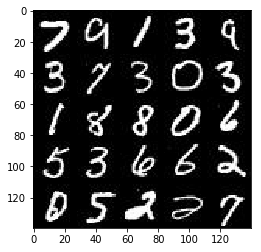

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

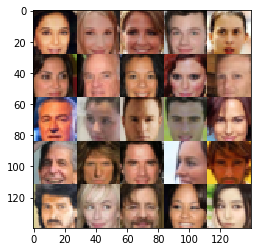

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.maximum(x * .1, x)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.maximum(x * .1, x)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.maximum(x * .1, x)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.maximum(x * .1, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.maximum(x * .1, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = tf.maximum(x * .1, x)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 0.5169... Generator Loss: 2.2587
Epoch 1/2... Discriminator Loss: 0.4560... Generator Loss: 2.6569
Epoch 1/2... Discriminator Loss: 0.4569... Generator Loss: 2.8278
Epoch 1/2... Discriminator Loss: 0.4371... Generator Loss: 3.3076
Epoch 1/2... Discriminator Loss: 0.3694... Generator Loss: 3.9571
Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 2.3495
Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 4.2929
Epoch 1/2... Discriminator Loss: 0.5222... Generator Loss: 3.2392
Epoch 1/2... Discriminator Loss: 0.3963... Generator Loss: 3.9377


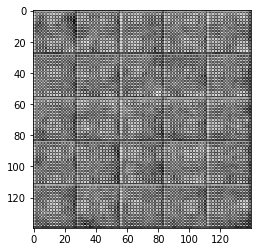

Epoch 1/2... Discriminator Loss: 0.3532... Generator Loss: 4.5016
Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 4.6109
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 4.3093
Epoch 1/2... Discriminator Loss: 0.4429... Generator Loss: 4.0003
Epoch 1/2... Discriminator Loss: 0.3670... Generator Loss: 4.2284
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 4.3003
Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 5.0081
Epoch 1/2... Discriminator Loss: 0.3487... Generator Loss: 4.6303
Epoch 1/2... Discriminator Loss: 0.3679... Generator Loss: 4.3736
Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 4.5838


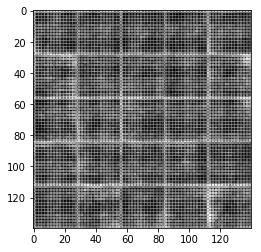

Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 4.9442
Epoch 1/2... Discriminator Loss: 0.3554... Generator Loss: 4.8730
Epoch 1/2... Discriminator Loss: 0.3894... Generator Loss: 3.2752
Epoch 1/2... Discriminator Loss: 2.9235... Generator Loss: 0.1621
Epoch 1/2... Discriminator Loss: 0.5331... Generator Loss: 2.2380
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 2.6716
Epoch 1/2... Discriminator Loss: 0.4197... Generator Loss: 3.1790
Epoch 1/2... Discriminator Loss: 0.3873... Generator Loss: 3.7089
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 0.4549... Generator Loss: 2.6581


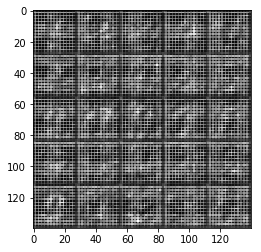

Epoch 1/2... Discriminator Loss: 0.4441... Generator Loss: 2.7760
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 1.4135
Epoch 1/2... Discriminator Loss: 0.5439... Generator Loss: 1.9695
Epoch 1/2... Discriminator Loss: 0.4418... Generator Loss: 2.6714
Epoch 1/2... Discriminator Loss: 0.6614... Generator Loss: 2.4481
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 1.3282
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 5.0075
Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 4.3703
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.5063


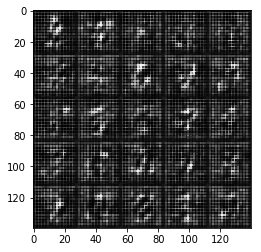

Epoch 1/2... Discriminator Loss: 0.5321... Generator Loss: 2.7263
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 4.4805
Epoch 1/2... Discriminator Loss: 0.6835... Generator Loss: 2.2978
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.1927
Epoch 1/2... Discriminator Loss: 0.6533... Generator Loss: 1.6116
Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.4752
Epoch 1/2... Discriminator Loss: 0.5960... Generator Loss: 2.3736
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 0.5734... Generator Loss: 1.9795
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.2549


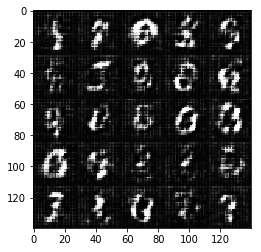

Epoch 1/2... Discriminator Loss: 0.6067... Generator Loss: 2.2705
Epoch 1/2... Discriminator Loss: 0.5407... Generator Loss: 2.1534
Epoch 1/2... Discriminator Loss: 0.5046... Generator Loss: 2.4263
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 0.8058... Generator Loss: 1.2558
Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 1.6961
Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 1.9147
Epoch 1/2... Discriminator Loss: 0.6983... Generator Loss: 1.4857
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 2.2215


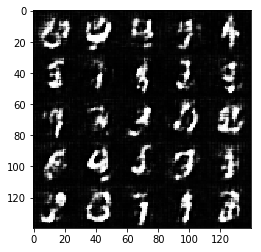

Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 2.7032
Epoch 1/2... Discriminator Loss: 0.6419... Generator Loss: 1.7416
Epoch 1/2... Discriminator Loss: 0.5963... Generator Loss: 2.4468
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 1.9114
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 0.6913... Generator Loss: 1.6948
Epoch 1/2... Discriminator Loss: 0.6858... Generator Loss: 1.5720
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 1.5140
Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 1.7740
Epoch 1/2... Discriminator Loss: 0.7454... Generator Loss: 2.3802


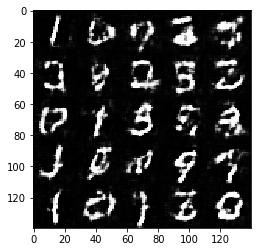

Epoch 1/2... Discriminator Loss: 0.7951... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 0.6341... Generator Loss: 2.3167
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.2619
Epoch 1/2... Discriminator Loss: 0.7422... Generator Loss: 1.4898
Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 0.9660
Epoch 1/2... Discriminator Loss: 0.7719... Generator Loss: 2.0202
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 1.1861
Epoch 1/2... Discriminator Loss: 0.7349... Generator Loss: 2.4406
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.3041
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 2.1839


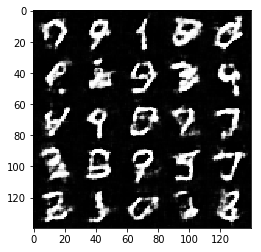

Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 2.9937
Epoch 1/2... Discriminator Loss: 0.7150... Generator Loss: 2.0661
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 2.1679
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.4148
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 1.6539
Epoch 1/2... Discriminator Loss: 0.7391... Generator Loss: 1.5458
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.2574
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 2.4670
Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 2.0366
Epoch 1/2... Discriminator Loss: 0.8360... Generator Loss: 1.1634


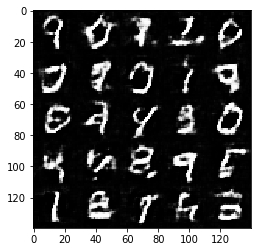

Epoch 1/2... Discriminator Loss: 0.8402... Generator Loss: 1.1220
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.3082
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.7109
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.7836
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.3366
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 0.6441... Generator Loss: 1.8921
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.1922
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.5571


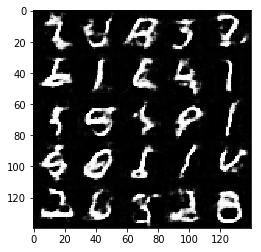

Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 2.3302
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.6331
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.0856
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.4964
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 0.9291
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 2.0162
Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 1.1819
Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 1.4160


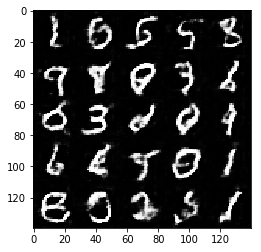

Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.9117
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.0421
Epoch 2/2... Discriminator Loss: 0.7064... Generator Loss: 1.6165
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 2.1415
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.2085
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 1.9134


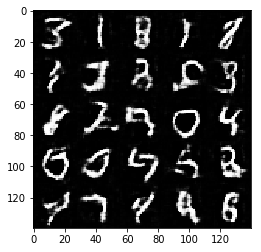

Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.7388
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.7775
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.3391
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.7444
Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.4224
Epoch 2/2... Discriminator Loss: 0.7953... Generator Loss: 1.2640
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.2592
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.8903
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 0.7925
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 0.7288


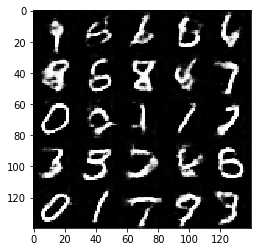

Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.7560
Epoch 2/2... Discriminator Loss: 0.6559... Generator Loss: 1.7685
Epoch 2/2... Discriminator Loss: 0.7560... Generator Loss: 1.8655
Epoch 2/2... Discriminator Loss: 0.6682... Generator Loss: 1.8563
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 0.6627... Generator Loss: 1.6545
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.3382
Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.5754
Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.6954


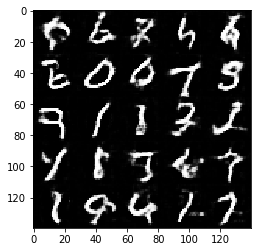

Epoch 2/2... Discriminator Loss: 0.7775... Generator Loss: 1.8629
Epoch 2/2... Discriminator Loss: 0.6610... Generator Loss: 1.9741
Epoch 2/2... Discriminator Loss: 0.7179... Generator Loss: 1.4369
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.3987
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 0.6961... Generator Loss: 1.6469
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 1.6524
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 1.7004
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.3746
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.9825


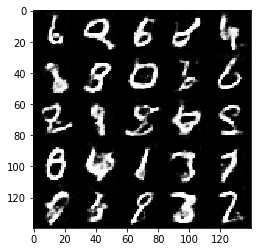

Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.4761
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.6390
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 1.1471
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 2.2745
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.6390
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 1.4650
Epoch 2/2... Discriminator Loss: 0.6695... Generator Loss: 1.6949
Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 1.5256
Epoch 2/2... Discriminator Loss: 1.0686... Generator Loss: 0.8091


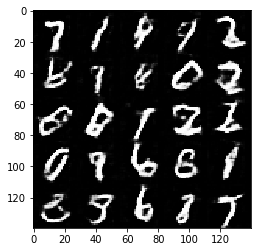

Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 1.3851
Epoch 2/2... Discriminator Loss: 0.8232... Generator Loss: 1.1920
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.7058
Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 2.4407
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.5515
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 2.1070
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.2458
Epoch 2/2... Discriminator Loss: 0.6119... Generator Loss: 1.9457
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.3034
Epoch 2/2... Discriminator Loss: 0.6526... Generator Loss: 1.9048


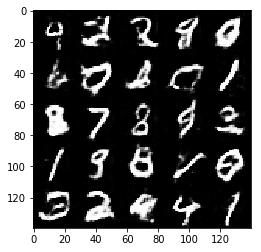

Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.7106
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 1.5337
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.5444
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.5134
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.4516
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.0974
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.9523
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 2.2821
Epoch 2/2... Discriminator Loss: 1.2453... Generator Loss: 0.7449


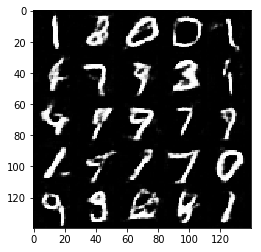

Epoch 2/2... Discriminator Loss: 0.5917... Generator Loss: 2.2843
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.0676
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.3940
Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 2.1220
Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 1.6838
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.1891


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.0886... Generator Loss: 0.0864
Epoch 1/1... Discriminator Loss: 1.7579... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 1.8115... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.7150
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.2331
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 7.7816
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 3.8967
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 2.9905
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.4805


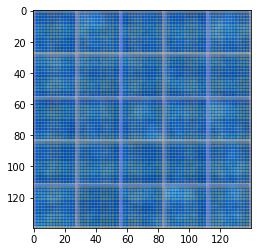

Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 3.8191
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 2.2719
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 2.7467... Generator Loss: 0.1417
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.7974
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 2.5897
Epoch 1/1... Discriminator Loss: 1.9281... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.7566


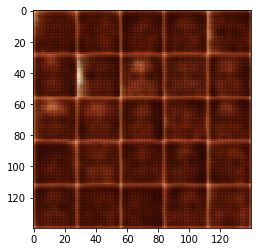

Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 3.6141
Epoch 1/1... Discriminator Loss: 1.8391... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.3313
Epoch 1/1... Discriminator Loss: 1.7457... Generator Loss: 0.3869
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 3.1726
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 2.3847
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.6436
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.2709


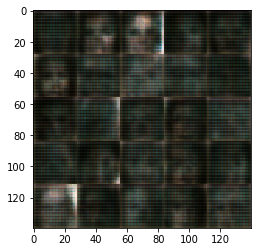

Epoch 1/1... Discriminator Loss: 2.3658... Generator Loss: 0.1963
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 2.0473
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.6963... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 2.5080
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6378


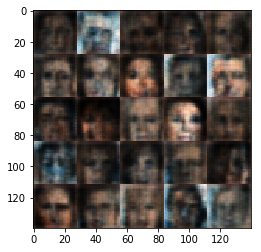

Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.8417
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.9983
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5286
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6829


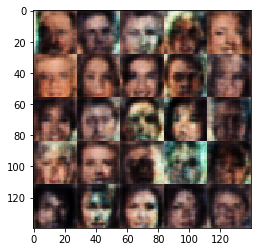

Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.8643... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 1.9128
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.3712


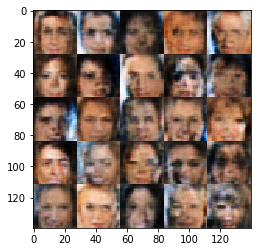

Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.4474


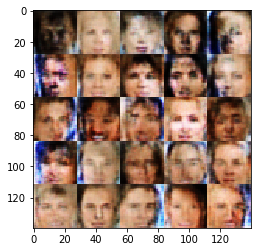

Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.5421


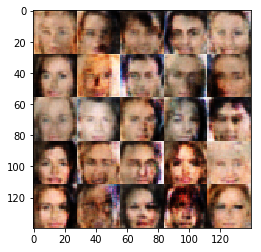

Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.5507
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.0056


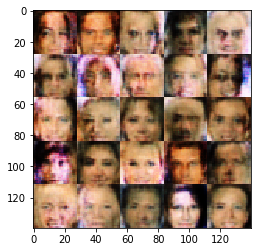

Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.4551
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.5982


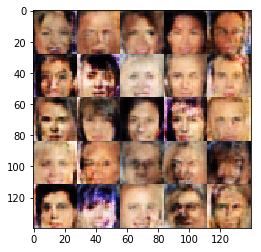

Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.3671
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.8995


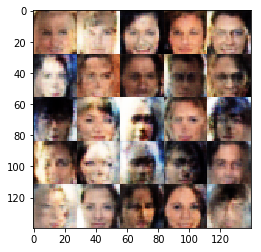

Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.0615


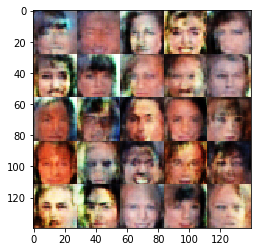

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9495


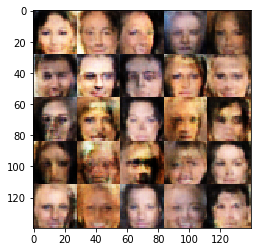

Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.8347
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.7621... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5035


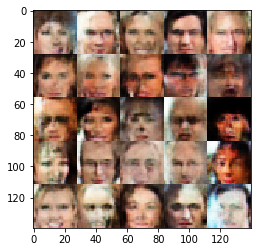

Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8974


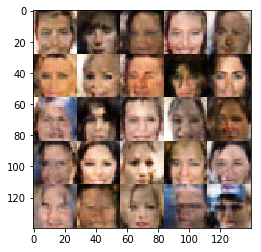

Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 0.9888


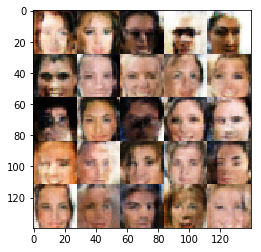

Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.5191


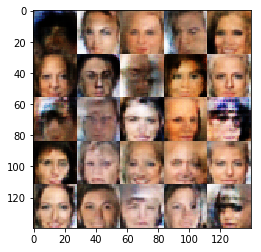

Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.6496
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.4971


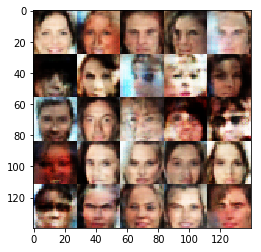

Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.7320


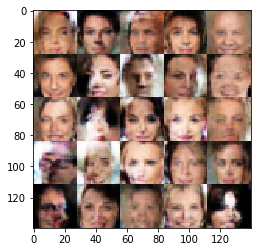

Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.3424
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.6988


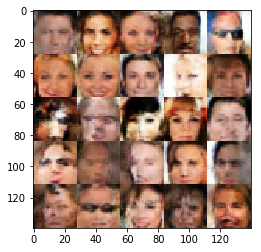

Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.0107


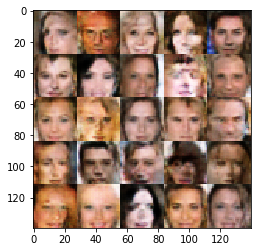

Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.7577


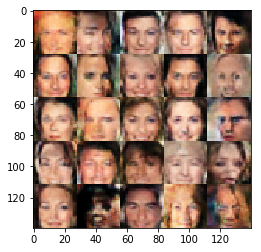

Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.2702
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.0473


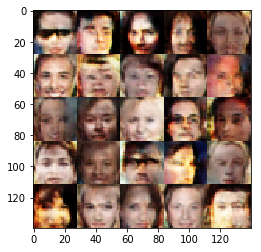

Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6773


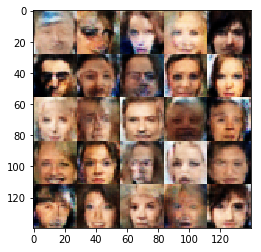

Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.6960... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9022


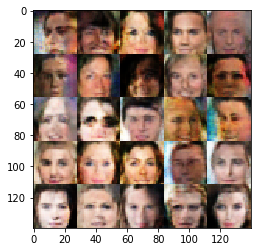

Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.5379


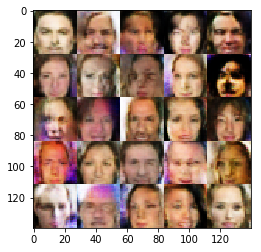

Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6214


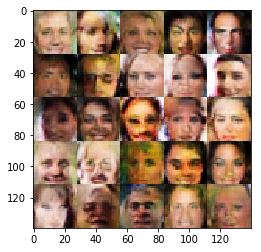

Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 2.1168... Generator Loss: 0.2464
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5100


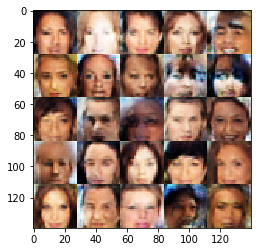

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.8774


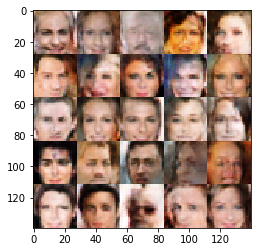

Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.3211
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.7092... Generator Loss: 0.3591


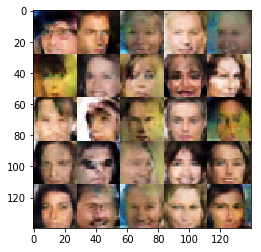

Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5845


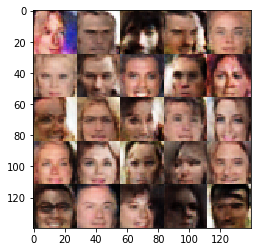

Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.9505


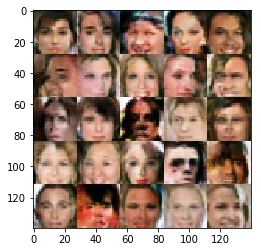

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.4243


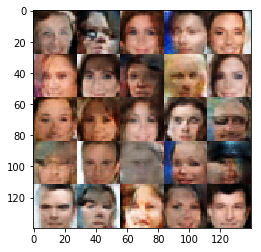

Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.1480... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.7697


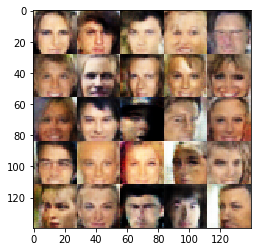

Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.7456


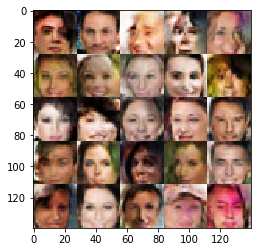

Epoch 1/1... Discriminator Loss: 1.9393... Generator Loss: 0.3580
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.6983... Generator Loss: 0.3417
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.6164... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5788


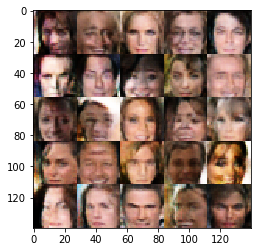

Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 0.3185
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 2.7492... Generator Loss: 0.1399
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.7997


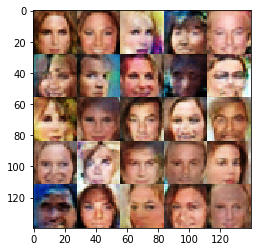

Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.9295


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.